# Single qubit gates
## First, isolated qubit

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [9]:
savefig = False
from matplotlib import rcParams
if savefig == True:
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
else:
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.serif'] = ['Arial']
    
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/'

In [97]:
#Device parameters
nlev_lc = 30
nlev_single = 5  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L = 0.5  # inductive energy
    E_C = 1.0  # charging energy
    E_J = 7  # Josephson energy
    phi_ext = 0.7*np.pi  # external phase shift

qubit = fluxonium.Fluxonium(E_J = E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)
H_nodrive = qubit.H()

#Gate parameter
T_gate = 20 #ns
t_points = np.linspace(0, T_gate, 100 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.5

comp_space = [0,1]
omega_d = qubit.freq(1,2) + delta_omega_d
matr_el = np.abs(qubit.n_ij(1,2))

epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
psi0 = basis(nlev_single, 0)
psi1 = basis(nlev_single, 1)
psi2 = basis(nlev_single, 2)
psi3 = basis(nlev_single, 3)
psi4 = basis(nlev_single, 4)

evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi2, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)

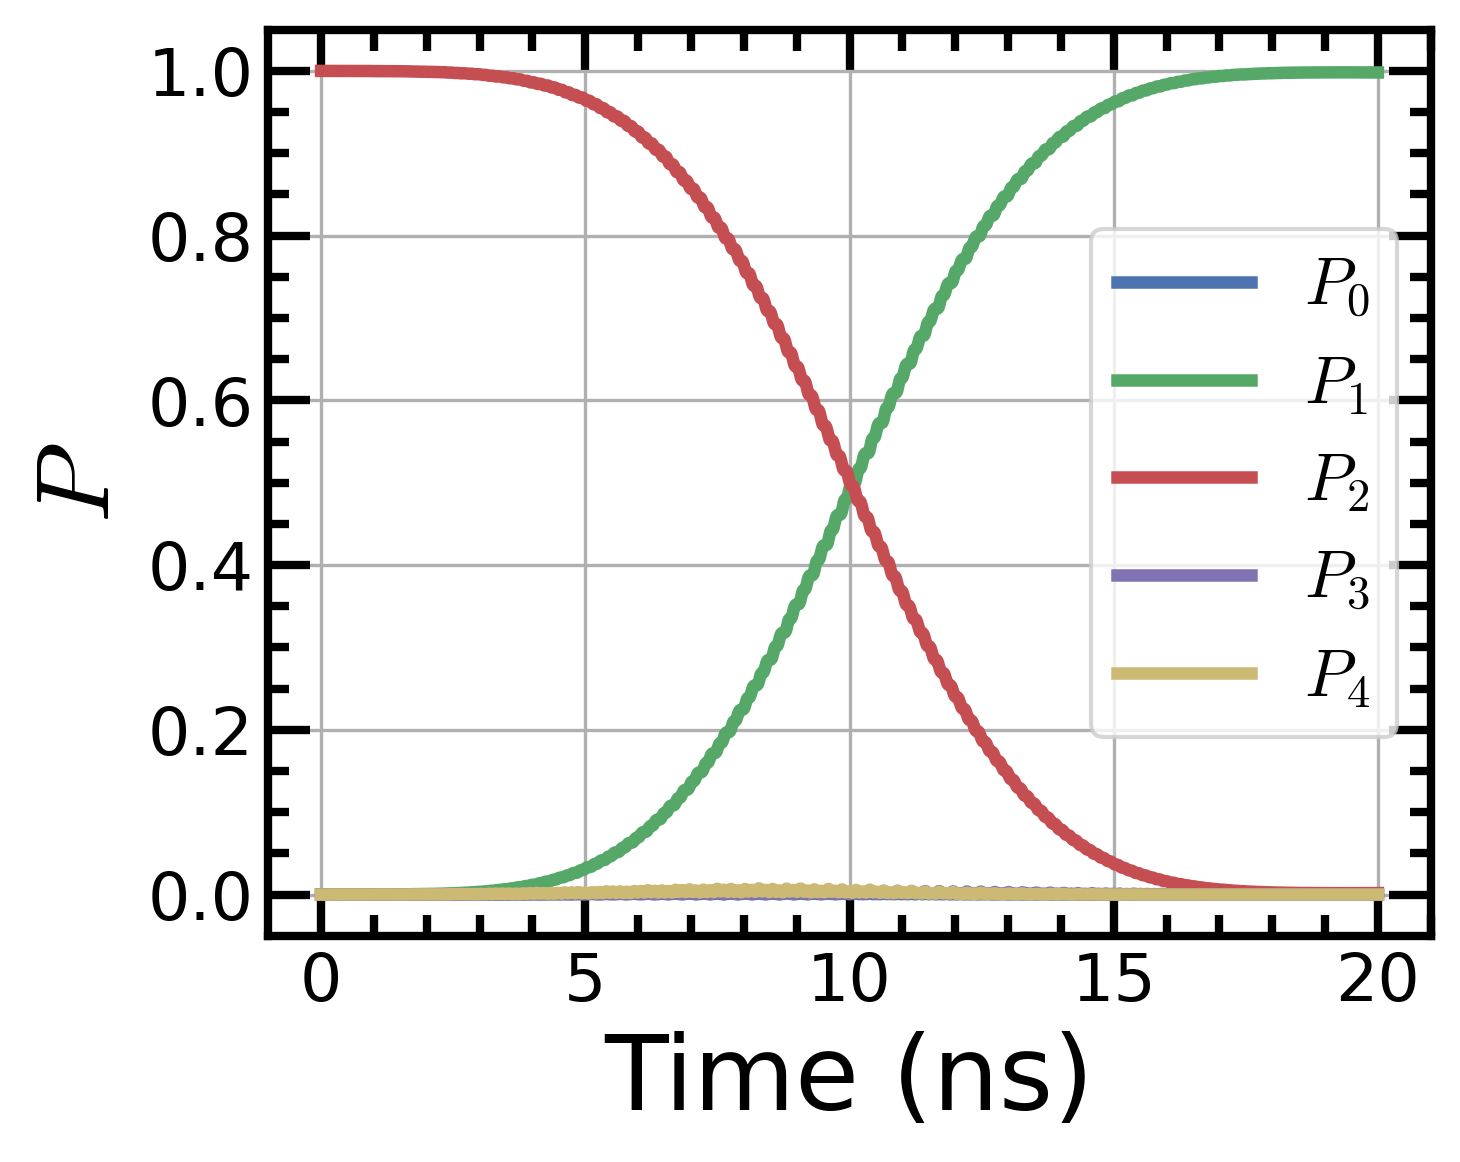

In [98]:
plt.figure(figsize = [5,4])
P0 = psi0 * psi0.dag()

P1 = psi1 * psi1.dag()
P2 = psi2 * psi2.dag()
P3 = psi3 * psi3.dag()
P4 = psi4 * psi4.dag()

plt.plot(t_points, expect(P0,evol_states_ideal), label = r'$P_0$')
plt.plot(t_points, expect(P1,evol_states_ideal), label = r'$P_1$')
plt.plot(t_points, expect(P2,evol_states_ideal), label = r'$P_2$')
plt.plot(t_points, expect(P3,evol_states_ideal), label = r'$P_3$')
plt.plot(t_points, expect(P4,evol_states_ideal), label = r'$P_4$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

In [100]:
## Optimization 
drag_coeff_array =np.linspace(0,1,101)
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
fidel = np.zeros_like(drag_coeff_array)
for idx, drag_coeff in enumerate(drag_coeff_array):
    evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi2, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)
    fidel[idx] = expect(P1,evol_states_ideal)[-1]

0.9922710387616894


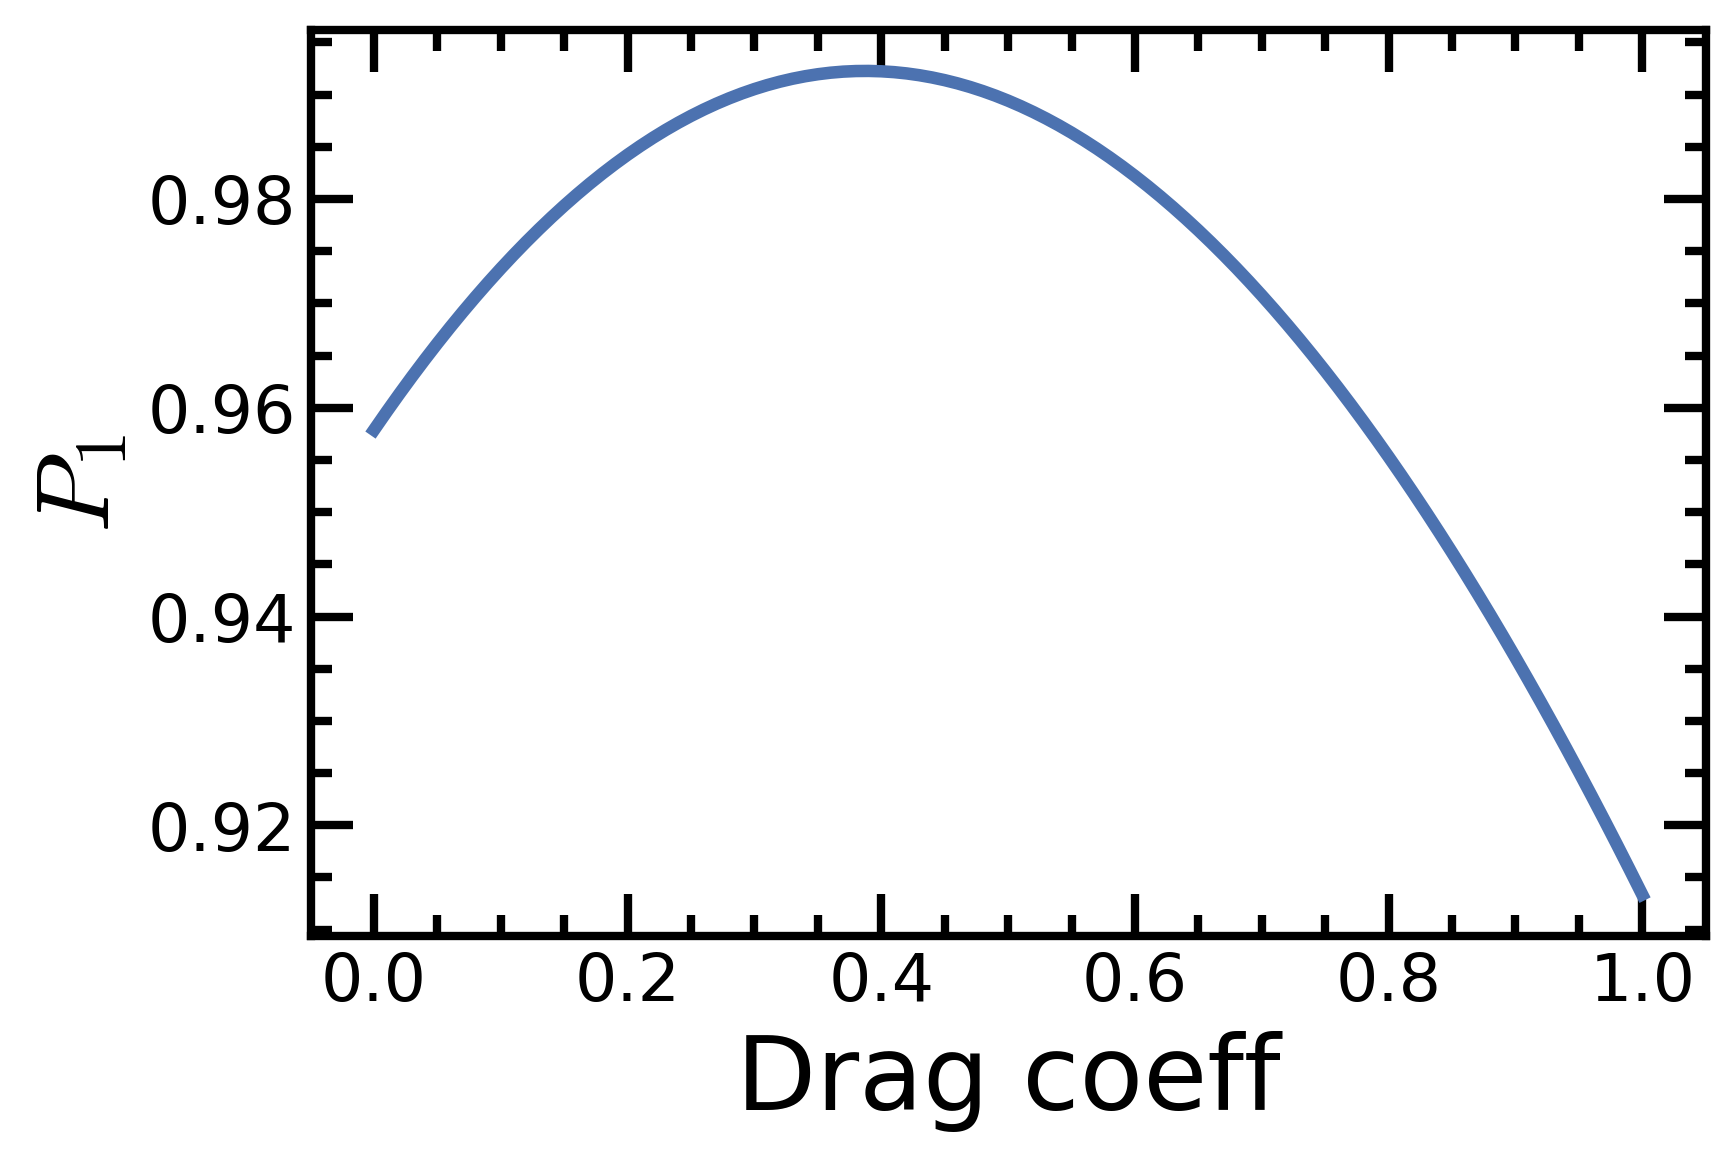

In [103]:
plt.plot(drag_coeff_array, fidel)
plt.xlabel( 'Drag coeff')
plt.ylabel(r'$P_1$')
print (np.max(fidel))

In [118]:
from scipy.optimize import minimize
def leakage_func(drag_coeff):
    evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi2, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)
    return (1- expect(P1,evol_states_ideal)[-1])
opt = minimize(leakage_func, x0 = [0.5])
print (opt.fun)

0.09965979410267234


## Sweep gate time, optimize parameters, plot leakage

In [119]:
gate_time = np.linspace(5,50,25)
leakage = np.zeros_like(gate_time)
for idx,T_gate in enumerate(gate_time):
    t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
    def leakage_func(drag_coeff):
        evol_states_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0 =psi2, t_points=t_points, DRAG = drag,
                                            T_gate=T_gate, shape=shape, omega_d=omega_d, DRAG_coefficient= drag_coeff)
        return (1- expect(P1,evol_states_ideal)[-1])
    opt = minimize(leakage_func, x0 = [0.5])
    leakage[idx] = opt.fun

(5.0, 50.0)

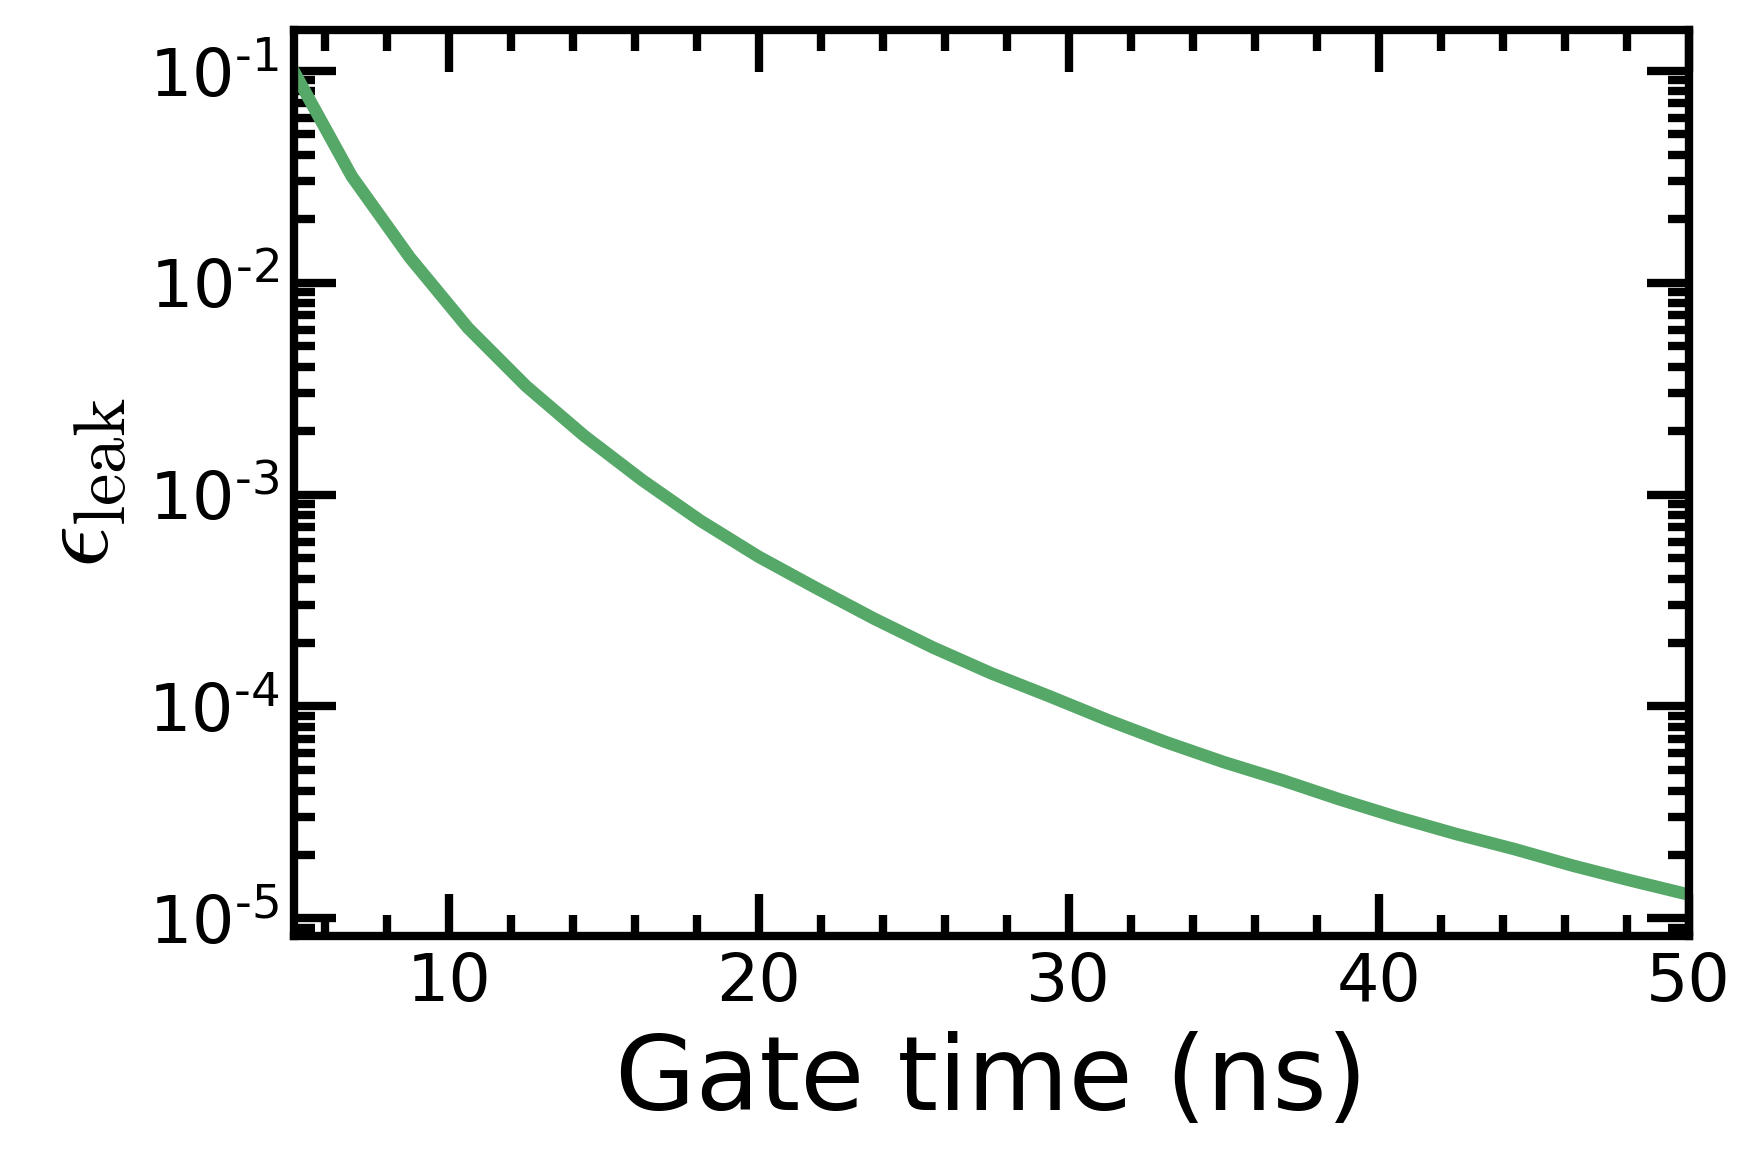

In [124]:
plt.semilogy(gate_time, leakage, color = 'C1')
plt.xlabel('Gate time (ns)')
plt.ylabel(r'$\epsilon_\mathrm{leak}$')
plt.xlim([gate_time[0], gate_time[-1]])

## Using propagator

99.98578313829324


Text(0.5, 1.0, '$\\mathcal{F}=$0.999858')

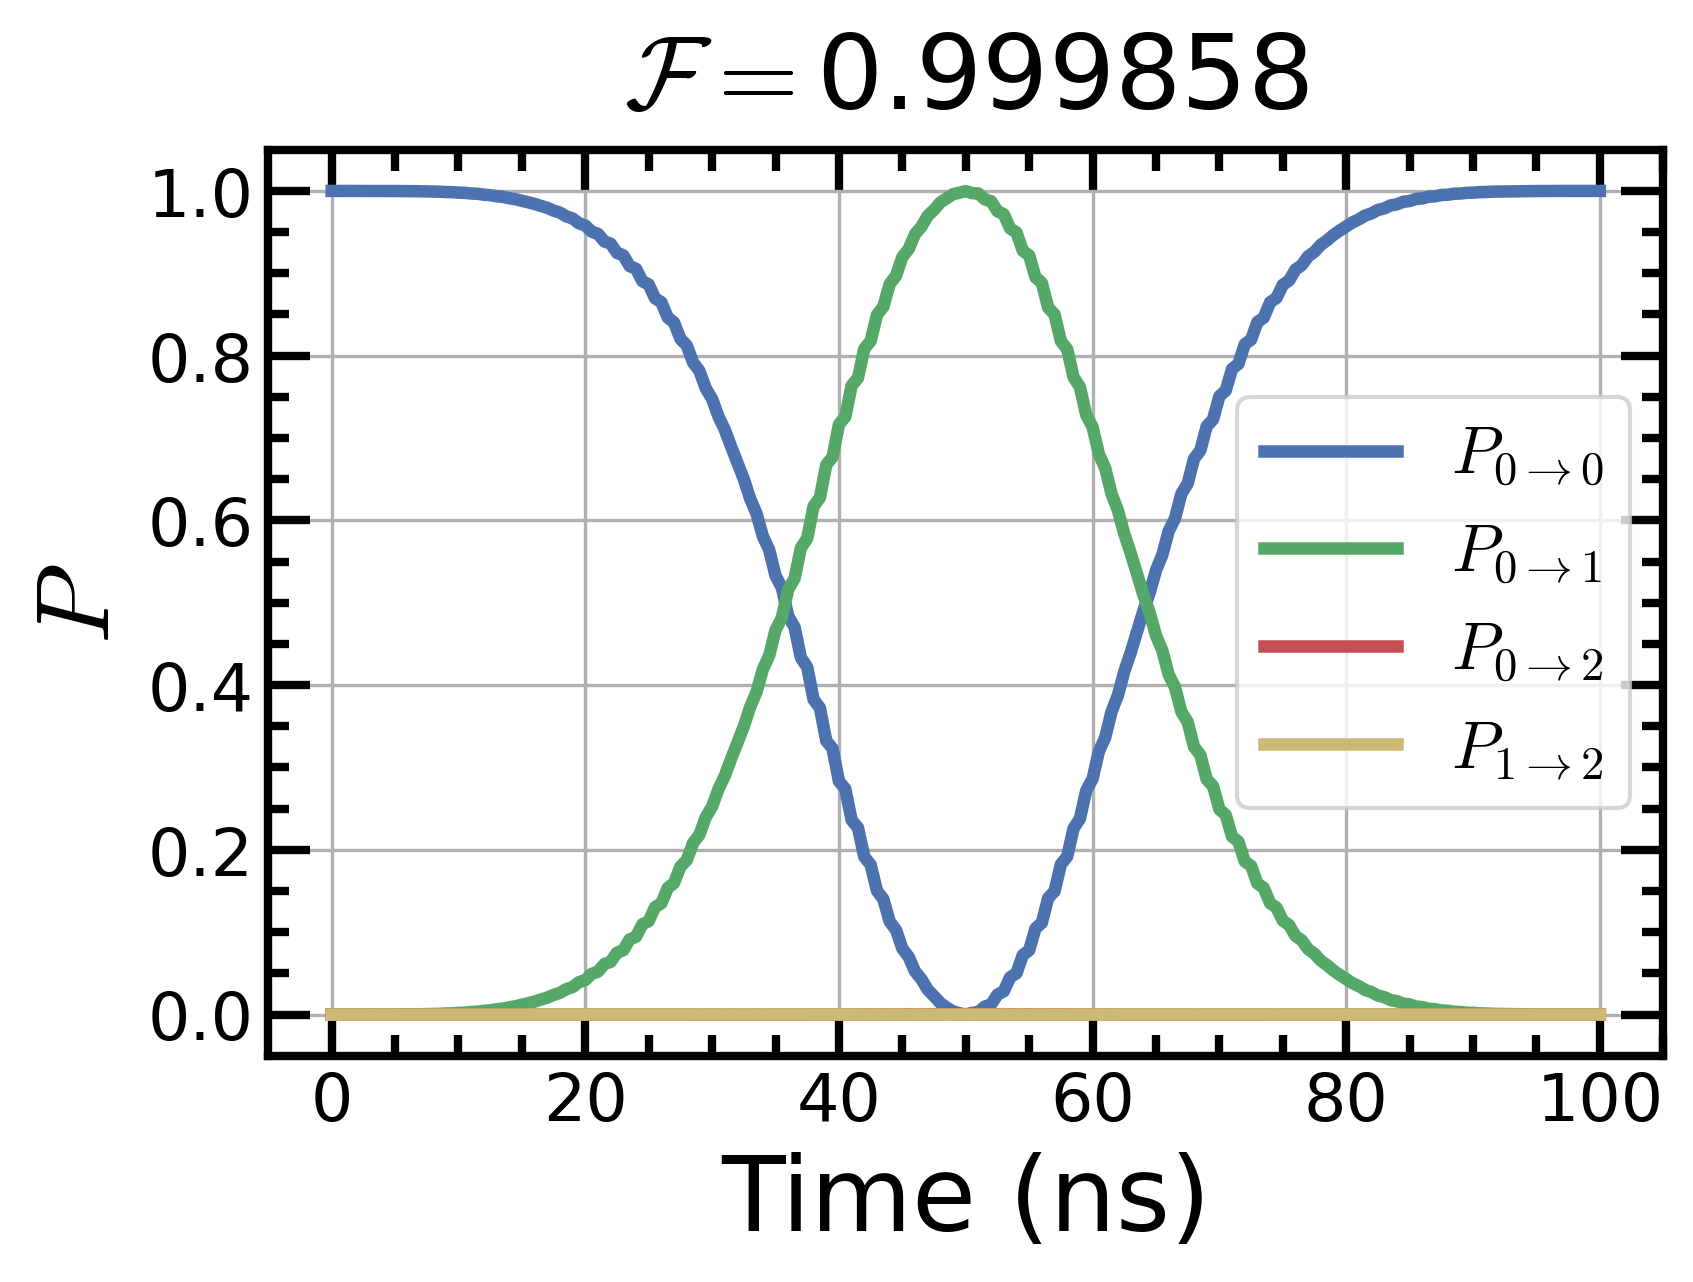

In [4]:
#Plotting results
state_0 = basis(nlev_single,0)
state_1 = basis(nlev_single,1)
state_2 = basis(nlev_single,2)
state_3 = basis(nlev_single,3)

#Fidelity
P = state_0*state_0.dag() + state_1*state_1.dag()
U_real = P*U_t[-1]*P

U_ideal = []
for idx in range(nlev_single):
    U_ideal = np.append(U_ideal, np.exp(-1j*2*np.pi*qubit.level(idx)*t_points[-1]))
U_ideal = Qobj(np.diag(U_ideal))
U_ideal = P*U_ideal*P   

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel*100)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))